# Trabalho #4 - Classificação multiclasse

Nesse trabalho você vai treinar uma rede para realizar uma tarefa de classificação multiclasse.

A tarefa é classificar imagens de dígitos numéricos chineses.

## Coloque seu nome aqui:

Aluno: Rodrigo Franciozi Rodrigues da Silva

RA: 20.83984-7

### Importação das principais bibliotecas

Em primeiro lugar é necessário importar alguns pacotes do Python que serão usados nesse trabalho.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1 - Visão geral do problema

O objetivo desse problema é determinar o dígito da lingua chinesa que é mostrado em uma imagem usando uma RNA. Assim, esse problema consiste em dada uma imagem, a RNA avalia a probabilidade de existirem determinados dígitos na imagem e determina qual o mais provável entre 15 possíveis.

O banco de dados usado nesse exemplo é o Chinese-MNIST, que consiste de imagens de dígitos chineses. Esse banco de dados pode ser obtido no Kaggle em https://www.kaggle.com/gpreda/chinese-mnist.

## 2 - Dados de treinamento

Características dos dados:

- O banco de dados Chinese MNIST possui 15.000 exemplos;
- Cada exemplo consiste de uma imagem em tons de cinza, de dimensão 64x64 pixels;
- Cada imagem é associada a um rótulo de 15 classes;
- O valor da intensidade luminosa de cada pixel da imagem é um número inteiro entre 0 e 255.

Primeiramente você deve acessar o link do Kaggle onde se encontra os dados e fazer download dos mesmos e descompactar o arquivo. 


### 2.1 Carregar dados

Após descompactar o arquivo com os dados execute as células abaixo para carregar e inspecionar os dados.

Note que os dados devem estar em uma pasta de nome `Chinese_MNIST` e as imagens estão dentro da pasta `Chinese_MNIST/data`.

O arquivo `chinese_mnist.csv` contém os nomes dos arquivos das imagens codificados e as classes de cada imagem.

In [3]:
# Carrega arquivo de informações sobre dados
path = '/content/drive/MyDrive/Education/IMT/Pós Graduação/IA com Deep Learning/Developing Neural Network Tools/Atividade 4/chinese_mnist.csv'
data_df = pd.read_csv(path)
data_df.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


### 2.2 Inspecionar dados

Vamos verificar o número de dados de cada classe de dígito, se existem dados ausentes e quantos arquivos de imagens existem.

In [4]:
data_df.groupby(["value","character"]).size()

value      character
0          零            1000
1          一            1000
2          二            1000
3          三            1000
4          四            1000
5          五            1000
6          六            1000
7          七            1000
8          八            1000
9          九            1000
10         十            1000
100        百            1000
1000       千            1000
10000      万            1000
100000000  亿            1000
dtype: int64

In [5]:
# Verifica se existem dados ausentes
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
character,0,0.0
value,0,0.0
code,0,0.0
sample_id,0,0.0
suite_id,0,0.0


In [6]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Education/IMT/Pós Graduação/IA com Deep Learning/Developing Neural Network Tools/Atividade 4/data.zip","r") as zip_ref:
  zip_ref.extractall("targetdir")

In [7]:
# Verifica número de arquivos de imagens existentes
image_files = list(os.listdir('targetdir/data'))
print("Numero de imagens: {}".format(len(image_files)))

Numero de imagens: 15000


### 2.3 Anexar propriedades das imagens ao dataframe

Como as imagens tem uma convenção de nome de `input_ [siote_id] _ [sample_id] _ [código] .jpg`, devemos criar mais uma coluna no dataframe com o nome do arquivo das imagens para podermos associar cada imagem à sua classe correspondente.

In [8]:
import skimage.io

def image_files(x):
    file_name = f"input_{x[0]}_{x[1]}_{x[2]}.jpg"
    return file_name
data_df["file"] = data_df.apply(image_files, axis=1)

def image_sizes(file_name):
    image = skimage.io.imread("Chinese_MNIST/data/" + file_name)
    return list(image.shape)

data_df = pd.concat([data_df],axis=1, sort=False)

data_df.head()

,suite_id,sample_id,code,value,character,file
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


## 3. Processamento dos dados

Primeiramente precisamos dividir os dados nos conjuntos de treinamento e teste. Vamos usar 80% para treinamento e 20% para teste/validação.

In [9]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_df, test_size = 0.2, random_state = 42, stratify = data_df["code"].values)

print("Train set: {}".format(train_df.shape))
print("Test set: {}".format(test_df.shape))

Train set: (12000, 6)
Test set: (3000, 6)


As imagens precisam ser carregadas, redimensionadas e normalizadas. Para isso vamos usar uma função que carrega as imagens, redimensiona-as para (64, 64) e normaliza os pixels para terem valores reais entre 0 e 1.

Precisamos também de uma função para criar a classe do dígito correspondente a cada imagem.

In [10]:
import skimage.transform

def read_image(file_name):
    #print(file_name)
    image = skimage.io.imread("targetdir/data/" + file_name)
    image = skimage.transform.resize(image, (64, 64), mode='reflect')
    return image

def categories_encoder(dataset, var='character'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

X_train, y_train = categories_encoder(train_df)
X_test, y_test = categories_encoder(test_df)

print('Dimensão do tensor das imagens de treinamento:', X_train.shape)
print('Dimensão do tensor das imagens de teste:', X_test.shape)
print('Dimensão do tensor de classes de treinamento:', y_train.shape)
print('Dimensão do tensor de classes de teste:', y_test.shape)

Dimensão do tensor das imagens de treinamento: (12000, 64, 64)
Dimensão do tensor das imagens de teste: (3000, 64, 64)
Dimensão do tensor de classes de treinamento: (12000, 15)
Dimensão do tensor de classes de teste: (3000, 15)


In [11]:
y_train

,一,七,万,三,九,二,五,亿,八,六,十,千,四,百,零
11415,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2317,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11346,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
10184,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5435,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
12449,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
13480,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
y_test

,一,七,万,三,九,二,五,亿,八,六,十,千,四,百,零
194,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11007,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
868,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4453,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2123,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11058,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4475,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8481,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
12866,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Como vamos processar as imagens com uma rede de camadas densas, devemos transformá-las em vetores.

In [13]:
# Redimensionamento das images 
X_train_flat = np.reshape(X_train, (12000, 64*64))
X_test_flat = np.reshape(X_test, (3000, 64*64))

# Transformação das saídas em tensor numpy
y_train = np.array(y_train)
y_test = np.array(y_test)

print('Dimensão do tensor das imagens de treinamento:', X_train_flat.shape)
print('Dimensão do tensor das imagens de teste:', X_test_flat.shape)
print('Dimensão do tensor de classes de treinamento:', y_train.shape)
print('Dimensão do tensor de classes de teste:', y_test.shape)
print('Valores mímnimo e máximo dos pixels das imagens:', np.min(X_train_flat), np.max(X_train_flat))

Dimensão do tensor das imagens de treinamento: (12000, 4096)
Dimensão do tensor das imagens de teste: (3000, 4096)
Dimensão do tensor de classes de treinamento: (12000, 15)
Dimensão do tensor de classes de teste: (3000, 15)
Valores mímnimo e máximo dos pixels das imagens: 0.0 0.9999999999999997


In [14]:
np.min(X_test_flat), np.max(X_test_flat) 

(0.0, 0.999999999999996)

y = 13 (y_hot=[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0])


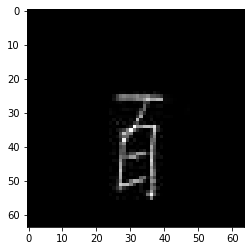

In [15]:
# Exemplo de uma imagem
index = 1
plt.imshow(X_train[index], cmap='gray')
print ("y = " + str(np.argmax(y_train[index])) + " (y_hot=" + str(y_train[index]) + ")")

## 3. Para você fazer

Você deve desenvolver uma rede neural usando a plataforma TensorFlow-Keras, para classificar os dígitos escritos em chinês.

Além de mostrar a configuração da rede utilizada, os parâmetros escolhidos para a compilação e treinamento, apresente pelo menos os seguintes resultados:

1. Resultado do processo de treinamento (gráficos);

2. Valores da função de custo e da métrica para os dados de treinamento e teste (use o método evaluate);

3. Gráfico com as classes previstas junto com as classes reais dos dados de teste. Use círculos de cores diferentes para diferenciar as classe previstas das reais.

4. Matriz de confusão dos resulatdos para facilitar a análise de desempenho da sua rede.

Para entregar o seu trabalho, transforme o seu notebook em pdf e faça o upload do mesmo nesse espaço.  

## RNA Setup

In [16]:
# PARA VOCÊ FAZER: Função para configuração da RNA

# Importa classes do Keras de modelos e camadas
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

def build_model(data_shape, n1, n2, n3, lamb):
    """
    Essa função configura uma rede neural deep-learnig
    
    Argumentos:
    data_shape = tuple com dimensões dos dados de entrada da rede
    n1 = número de neurônios da primeira camada
    n2 = número de neurônios da segunda camada
    n3 = número de neurônios da camada de saída     
    Retorna: modelo da rede neural
    """
    # Inicialização do gerador de números aleatórios para permitir verificar resultados
    np.random.seed(3)
    
    model = models.Sequential()
    
    model.add(Dense(units = n1, activation='relu', input_shape = data_shape))
    model.add(Dropout(0.2))
    model.add(Dense(units = n2, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = n3, activation='softmax'))
    
    #kernel_regularizer=regularizers.l2(lamb)

    return model

In [17]:
# Dimensão dos dados de entrada
data_shape = (64*64, )

# Neurônios
N1 = 128
N2 = 64
N3 = 15
lamb = 0.005

rna = build_model(data_shape = data_shape, n1 = N1, n2 = N2, n3 = N3, lamb = lamb)
rna.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               524416    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                975       
Total params: 533,647
Trainable params: 533,647
Non-trainable params: 0
_________________________________________________________________


In [19]:
BATCH_SIZE = 1024
EPOCHS = 100

# importa do keras a classe dos otimizadores e escolhe as métricas
from tensorflow.keras import optimizers
from tensorflow import keras

METRICS = [
keras.metrics.BinaryAccuracy(name='accuracy'),
keras.metrics.Precision(name='precision'),
keras.metrics.Recall(name='recall')
]

# Configuração do otimizador
adam = optimizers.Adam(learning_rate = 0.001)

#Treinamento
rna.compile(loss = 'categorical_crossentropy', metrics = METRICS, optimizer = adam)

history = rna.fit(X_train_flat, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose=0)

## Results

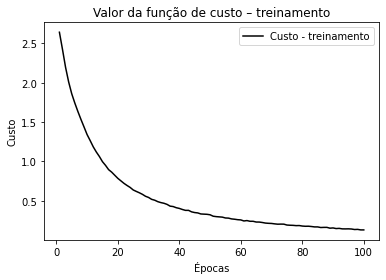

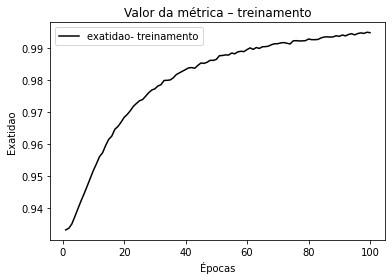

In [20]:
# Salva treinamento na variável history para visualização
history_dict = history.history

# Salva custos, métricas e epocas em vetores 
custo = history_dict['loss']
acc = history_dict['accuracy']

# Cria vetor de épocas
epocas = range(1, len(custo) + 1)

# Gráfico dos valores de custo
plt.plot(epocas, custo, 'k', label='Custo - treinamento')
plt.title('Valor da função de custo – treinamento')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocas, acc, 'k', label='exatidao- treinamento')
plt.title('Valor da métrica – treinamento')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

## Validation

In [21]:
custo_e_metricas_train = rna.evaluate(X_train_flat, y_train)
custo_e_metricas_test = rna.evaluate(X_test_flat, y_test)

print('Dados de treinamento: ', custo_e_metricas_train)
print('Dados de Teste: ', custo_e_metricas_test)

94/94 [==============================] - 1s 5ms/step - loss: 0.7776 - accuracy: 0.9753 - precision: 0.8319 - recall: 0.7883
Dados de treinamento:  [0.03272426873445511, 0.9995497465133667, 0.9978280663490295, 0.9954166412353516]
Dados de Teste:  [0.777620255947113, 0.9752665758132935, 0.8318677544593811, 0.7883333563804626]


## Prediction

In [22]:
y_prev = rna.predict(X_test_flat)
classe = np.argmax(y_prev, axis=1)
y_test_plot = np.argmax(y_test, axis= 1)

print(classe[:150])
print(y_test_plot[:150])

[ 4  6  4  2 13  5 13 14  0  9  2  8 12  1 10  4 10 12  7  1  8  1  2 13
  2 10  1  8  7  6 13  9  5  1  0  0  3  5 13  5  1  4  2  0  7  0 11 12
 11 11 10 14  5  8 10  3  7  3  5 14  2 10 11  2  0 11 14  7 11  4  3  7
 11  7  9  0  3  4  8  9 12  8  2  2  6  5  8  9  6  6  5  7  9  8  7  4
 13  9  3  3  3  3  1  6  9  2 12 10  1  7 11  2  5  7  7 14  1  6  9 12
  6 14  5 12  9 14  6 11  0 14 11  2  6  2 11 11  5  8 13 13 14  0  3  5
  2 14 11 12 14  5]
[ 4  6  4  2 13  3 13 14  0  9  2  8 12  1 10  9 10 12  7 11  9  1  2 13
  2 10  1  8  4  6 13  9  5  1  0  0  3  3 13  5  1  4  2  5  7  0 10 12
 11 14 10 14  5  8 10  3  4  3  5 14  2 10 11  2  0 11 13  7 11  4  3  7
 10  7  9  9  3  4  2  8 12  8  2  2 13  5  8  9  6  6  3  7  9  8  7  4
 13  6  3  3  3  5  6  6  9  2 13 10  1  7 11  2  5  7 12 14  1  6  2 12
  6 14  5 12  9 13  6 10  0 14 11  8  6  4 11 11  5  8 13 13 14  0  3  5
  2 14 14 12 14  0]


Dimensão vetor classes reais=  (3000,)
Dimensão vetor classes previstas=  (3000,)


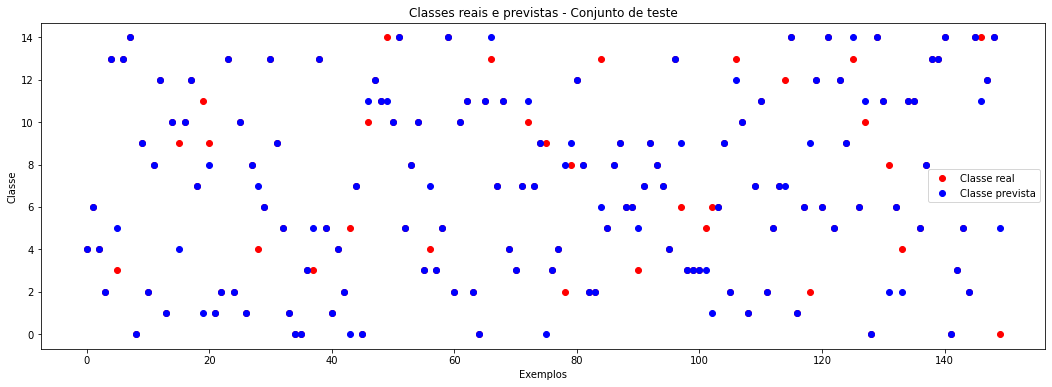

In [23]:
# Resultado gráfico
print('Dimensão vetor classes reais= ', y_test_plot.shape)
print('Dimensão vetor classes previstas= ', classe.shape)

plt.figure(figsize=(18, 6))
plt.plot(y_test_plot[:150], 'ro', label='Classe real')
plt.plot(classe[:150], 'bo', label='Classe prevista')
plt.title('Classes reais e previstas - Conjunto de teste')
plt.xlabel('Exemplos')
plt.ylabel('Classe')
plt.legend()
plt.show()

## Confusion Matrix

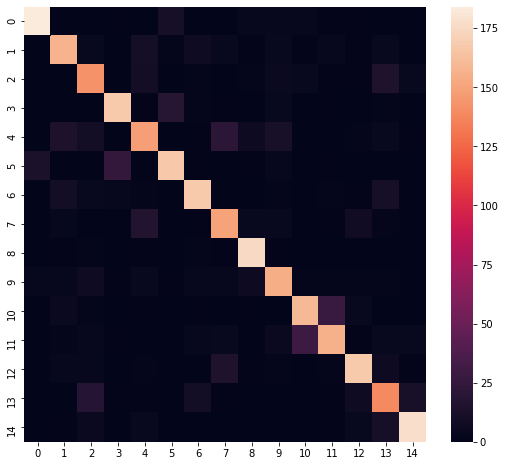

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

ax, f = plt.subplots(figsize = (9, 8))
confusion = confusion_matrix(classe, y_test_plot)
sns.heatmap(confusion)